# KKUI CIT Course - Neural networks - Week_07 - CNN Images

In [52]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.io as pio
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torchsummary import summary
import plotly.graph_objs as go
import plotly.io as pio
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [53]:
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

batch_size = 32
# Define a list of label names corresponding to the classes in the FashionMNIST dataset.
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# This function is a collate function for data loading in PyTorch. It's used with DataLoader to preprocess batches of data.
# It takes a batch of data samples as input and performs the necessary preprocessing steps.

def collate_fn(batch):
    # Define a series of transformations to apply to each image in the batch.
    process = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL images to PyTorch tensors.

        # transforms.Pad([2]),     # Pad each image with 2 pixels on all sides.
    ])

    # Process each image in the batch using the defined transformations.
    # We use a list comprehension to apply the transformations to each image in the batch.
    x = [process(data[0]) for data in batch]

    # Concatenate the processed images along a new dimension to create a batch tensor.
    # We add a new dimension because PyTorch expects input data to be in the format (batch_size, channels, height, width).
    x = torch.cat(x).unsqueeze(1)

    # Extract labels from the batch of data samples and convert them to LongTensor.
    # It's important to use LongTensor for labels to match the expected data type for classification tasks.
    y = torch.LongTensor([data[1] for data in batch])

    # Return the processed batch of images (x) along with their corresponding labels (y).
    return x, y


# Download or load the FashionMNIST dataset for training and validation.
# If the dataset is not available locally, it will be downloaded to the specified directory.
train_data = FashionMNIST("./data/MNIST_DATA", train=True, download=True)  # Training data
valid_data = FashionMNIST("./data/MNIST_DATA", train=False, download=True)  # Validation data

# Create DataLoader objects to load batches of training and validation data.
# DataLoader is a PyTorch utility for batching and shuffling data during training.
# It takes the dataset, batch size, shuffle option, and collate function as parameters.
train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)  # Training DataLoader
valid_loader = DataLoader(valid_data, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_fn)  # Validation DataLoader


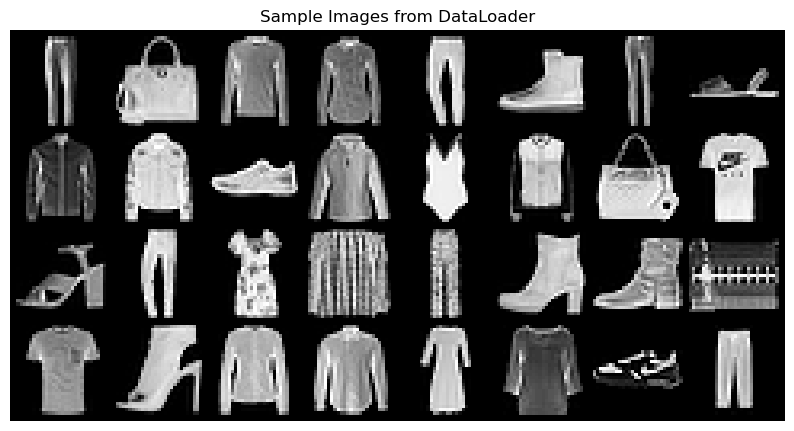

In [54]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

# Extracting a batch of data from train_loader
batch = next(iter(train_loader))

# Assuming the batch consists of images
images = batch[0]  # Assuming 'image' is the key for images in your batch

# # Assuming batch size is constant
# batch_size = len(images)

# Convert the tensor batch of images to numpy arrays for plotting
image_grid = make_grid(images).numpy()

# Plotting the images
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(image_grid, (1, 2, 0)))  # Matplotlib expects image data in (height, width, channels) format
plt.axis('off')  # Turn off axis
plt.title('Sample Images from DataLoader')
plt.show()

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding="same", stride=1)
        self.con2  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same")
        # Define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Define fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Assuming input image size is 32x32
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Reshape tensor for fully connected layers
        x = x.view(-1, 32 * 7 * 7)  # Assuming input image size is 32x32
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model_simple_cnn = SimpleCNN(num_classes=10)
print(model_simple_cnn)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [40]:
summary(model_simple_cnn, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 128]         200,832
            Linear-6                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.79
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


In [41]:
images[0][0].shape

torch.Size([28, 28])

In [45]:
learning_rate = 0.001  # Learning rate for optimizer
criterion = nn.CrossEntropyLoss() # is not possible to use binary cross entropy


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_simple_cnn.to(DEVICE)# Loss criterion (Mean Squared Error)
optimizer = torch.optim.AdamW(model_simple_cnn.parameters(), lr=learning_rate, weight_decay=1e-5)
# AdamW optimizer with specified learning rate and weight decay

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()  # Gradient scaler for mixed precision training

steps = 0  # Variable to track the number of training steps

In [46]:
from tqdm.notebook import tqdm


def train(model, dataloader, criterion, optimizer, scaler, save_distrib=False):
    """
    Function to train the autoencoder model.

    Parameters:
        model (nn.Module): Autoencoder model to be trained.
        dataloader (DataLoader): DataLoader containing the training data.
        criterion: Loss criterion used for training.
        optimizer: Optimization algorithm used for updating model parameters.
        scaler: Gradient scaler for mixed precision training.
        save_distrib (bool): Flag to indicate whether to save latent space plots.

    Returns:
        float: Average training loss over all batches.
    """
    # steps is used to track training progress, purely for latent space plots
    global steps

    model.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize training loss

    # Initialize tqdm progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Train")
    batch_acc_aggregator = []
    batch_loss_aggregator = []
    for i, batch in enumerate(dataloader):

        optimizer.zero_grad()  # Reset gradients
        x = batch[0].to(DEVICE)  # Move data to device
        y = batch[1].to(DEVICE)#
        # Implement mixed precision training
        with torch.cuda.amp.autocast():
            # x = x.view(-1, 1* 28* 28)
            x = x.view(x.size(0), -1)
            y_recons = model(x)  # Forward pass
            # print(y_recons.shape)

            loss = criterion(y_recons, y)  # Compute loss

        train_loss += loss.item()  # Update training loss
        batch_loss_aggregator.append(loss.item())
        scaler.scale(loss).backward()  # Backpropagate gradients
        scaler.step(optimizer)  # Update model parameters
        scaler.update()  # Update gradient scaler

        # Saving latent space plots
        # if steps % 10 == 0 and save_distrib and steps <= 400:
        #     plotting(steps)

        batch_bar.update()  # Update progress bar
        steps += 1  # Increment training steps

        torch.cuda.empty_cache()  # Clear GPU cache


        # calculate accuracy
        _, predicted = torch.max(y_recons, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)
        batch_acc_aggregator.append(accuracy)

        # Update tqdm progress bar with current loss and learning rate
        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            # acc=f"{accuracy/(i+1):.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        del x, y_recons


    batch_bar.close()  # Close tqdm progress bar
    train_loss /= len(dataloader)  # Compute average training loss
    # Calculate accuracy

    return batch_acc_aggregator, batch_loss_aggregator  # Return average training loss


In [47]:
def validate(model, dataloader, criterion):
    """
    Function to validate the autoencoder model.

    Parameters:
        model (nn.Module): Autoencoder model to be validated.
        dataloader (DataLoader): DataLoader containing the validation data.
        criterion: Loss criterion used for validation.

    Returns:
        float: Average validation loss over all batches.
    """
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0  # Initialize validation loss

    # Initialize tqdm progress bar for validation
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")
    batch_acc_aggregator = []
    batch_loss_aggregator = []
    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)
        y = batch[1].to(DEVICE)# Move data to device
        # x = x.view(-1, 1 * 28* 28)
        # x = x.view(x.size(0), -1)
        with torch.no_grad():
            y_recons = model(x)  # Forward pass (no gradient calculation)
            loss = criterion(y_recons, y )  # Compute loss

        valid_loss += loss.item()
        batch_loss_aggregator.append(loss.item())# Update validation loss
        # calculate accuracy
        _, predicted = torch.max(y_recons, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)
        batch_acc_aggregator.append(accuracy)

        # Update tqdm progress bar with current loss and learning rate
        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            # acc=f"{accuracy/(i+1):.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        del x, y_recons

    batch_bar.close()  # Close tqdm progress bar
    valid_loss /= len(dataloader)  # Compute average validation loss

    return batch_acc_aggregator, batch_loss_aggregator  # Return average validation loss


In [48]:
epochs = 10  # Number of epochs for training

train_acc_agg = []
train_loss_agg = []

valid_acc_agg = []
valid_loss_agg = []
for i in range(epochs):

    curr_lr = float(optimizer.param_groups[0]["lr"])  # Current learning rate
    # Train the model for one epoch
    train_acc, train_loss = train(model_simple_cnn, train_loader, criterion, optimizer, scaler, save_distrib=True)
    train_acc_agg.append(np.mean(train_acc))
    train_loss_agg.append(np.mean(train_loss))

    # Validate the model
    valid_acc, valid_loss = validate(model_simple_cnn, valid_loader, criterion)
    valid_acc_agg.append(np.mean(valid_acc))
    valid_loss_agg.append(np.mean(valid_loss))
    # Print epoch-wise training and validation losses along with current learning rate
    print(f"Epoch {i+1}/{epochs}\nTrain accuracy: {train_acc_agg[-1]:.4f}\tTrain loss: {train_loss_agg[-1]:.4f}\t Validation accuracy: {valid_acc_agg[-1]:.4f}Validation loss: {valid_loss_agg[-1]:.4f}\tlr: {curr_lr:.4f}")


Train:   0%|          | 0/1875 [00:00<?, ?it/s]

/Users/hlibokymaros/opt/anaconda3/envs/KKUI-PPV_LABs/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 784]